# <a id='toc1_'></a>[Figures](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Figures](#toc1_)    
  - [Functions used to simulate the magnetic field](#toc1_1_)    
  - [Accuracy results](#toc1_2_)    
  - [Weights analysis](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [38]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)
n_iterations = 10

## <a id='toc1_1_'></a>[Functions used to simulate the magnetic field](#toc0_)

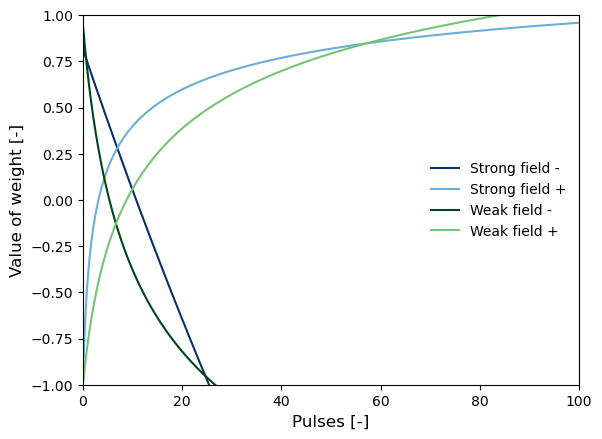

In [39]:
scale = 1
f_strong_minus = lambda x: scale * (2*(-24.77 * \
                torch.log(0.287*torch.log(x+128))+9.11)-1)
f_strong_plus = lambda x: scale * (2*(0.443 * \
                torch.log(2.53*torch.log(x+1.66)) - 0.11)-1)

f_weak_minus = lambda x: scale * \
                (-2.56*torch.log(0.997*torch.log(x+5.02)) + 2.166)
f_weak_plus = lambda x: scale * \
                (1.8132 * torch.log(1.176*torch.log(x+4.42))-2.014)
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
ax.set_ylim(-scale, scale)
ax.set_xlim(0, 100)
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## Load results from simulations

In [40]:
# Create a pandas dataframe with columns type, mean, std, learning rate
df = pd.DataFrame(columns=["task", "type_devices", "n_devices", "accuracies", "learning_rate", "weights_path", "mean", "std", "scale", "noise", "mean_abs_grad"])
# get all paths
paths = [f for f in os.listdir(SIMULATION_FOLDER) if os.path.isdir(os.path.join(SIMULATION_FOLDER, f)) and ("simple" in f or "double" in f)]

for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    mean_abs_grad = []
    weights = ""
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
        mean_abs_grad.append(torch.load(os.path.join(current_folder, path+f"-{it}-gradients.pth")))
        if it == 0:
            weights = path+f"-{it}-weights.pth"     
    accuracies = torch.stack(accuracies)    
    mean = accuracies.mean(dim=0)[-1].item()*100
    std = accuracies.std(dim=0)[-1].item()*100
    mean_abs_grad = torch.stack(mean_abs_grad).mean(dim=0)[0].item()
    task = path.split("-")[1]
    n_devices = path.split("-")[2]
    type_devices = path.split("-")[3]
    learning_rate = float(path.split("-")[4])
    scale = float(path.split("-")[8])
    noise = float(path.split("-")[10])
    df = df.append({"task": task, 
                    "type_devices": type_devices, 
                    "n_devices": n_devices, 
                    "accuracies": accuracies, 
                    "learning_rate": learning_rate, 
                    "weights_path": weights, 
                    "mean": mean, 
                    "std": std,
                    "mean_abs_grad": mean_abs_grad,
                    "noise": noise,
                    "scale": scale}, ignore_index=True)
df

,task,type_devices,n_devices,accuracies,learning_rate,weights_path,mean,std,scale,noise,mean_abs_grad
0,MNIST,exponential,double,"[[tensor(0.9594), tensor(0.9682), tensor(0.971...",0.5,20240722150521-MNIST-double-exponential-0.5-sw...,97.801000,0.054457,1.0,0.0,0.000288
1,MNIST,exponential,double,"[[tensor(0.9525), tensor(0.9645), tensor(0.968...",1.0,20240722150713-MNIST-double-exponential-1.0-sw...,97.496003,0.058157,1.0,0.0,0.000355
2,MNIST,exponential,double,"[[tensor(0.9254), tensor(0.9453), tensor(0.953...",5.0,20240722150903-MNIST-double-exponential-5.0-sw...,96.504003,0.145923,1.0,0.0,0.000515
3,MNIST,exponential,double,"[[tensor(0.9079), tensor(0.9324), tensor(0.940...",10.0,20240722151057-MNIST-double-exponential-10.0-s...,95.641005,0.131694,1.0,0.0,0.000600
4,MNIST,exponential,double,"[[tensor(0.8550), tensor(0.8905), tensor(0.889...",50.0,20240722151251-MNIST-double-exponential-50.0-s...,92.291003,0.349172,1.0,0.0,0.001366
5,MNIST,exponential,double,"[[tensor(0.8540), tensor(0.8592), tensor(0.860...",100.0,20240722151444-MNIST-double-exponential-100.0-...,90.679997,0.435149,1.0,0.0,0.002934
6,MNIST,linear,double,"[[tensor(0.9631), tensor(0.9702), tensor(0.972...",0.5,20240722151638-MNIST-double-linear-0.5-switch-...,97.953999,0.062753,1.0,0.0,0.000854
7,MNIST,linear,double,"[[tensor(0.9630), tensor(0.9695), tensor(0.972...",1.0,20240722151821-MNIST-double-linear-1.0-switch-...,98.001993,0.057310,1.0,0.0,0.001224
8,MNIST,linear,double,"[[tensor(0.9569), tensor(0.9668), tensor(0.971...",5.0,20240722152004-MNIST-double-linear-5.0-switch-...,97.885001,0.064679,1.0,0.0,0.002293
9,MNIST,linear,double,"[[tensor(0.9479), tensor(0.9618), tensor(0.966...",10.0,20240722152148-MNIST-double-linear-10.0-switch...,97.769004,0.076660,1.0,0.0,0.002724


## Accuracy vs learning rate

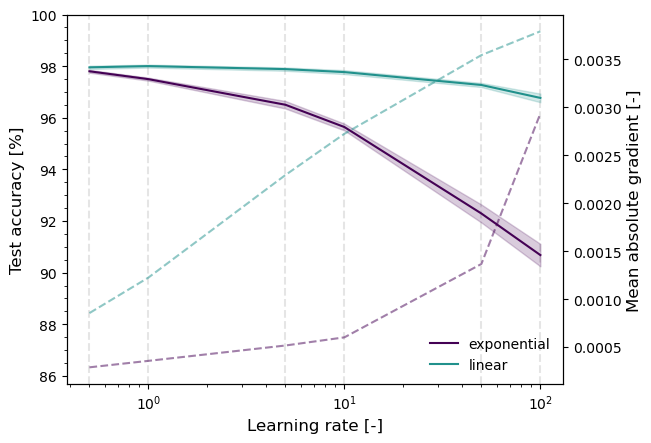

In [41]:
# for each task, plot the evolution of the accuracy
for task in df["task"].unique():
    fig, ax = plt.subplots()
    
    ax2 = ax.twinx()
    
    palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
    df_filtered = df[(df["task"] == task) & (df["noise"] == 0.0)]
    for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):
        ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i))
        ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
        ax2.plot(group["learning_rate"], group["mean_abs_grad"], linestyle='--', color=palette(i), alpha=0.5, zorder=-1)
    for lr in df_filtered["learning_rate"].unique():
        ax.axvline(lr, color='black', linestyle='--', alpha=0.1, zorder=-1)
    ax.set_xscale('log')
    ax2.set_ylabel("Mean absolute gradient [-]", fontsize=12)
    ax.set_xlabel("Learning rate [-]", fontsize=12)
    ax.set_ylabel("Test accuracy [%]", fontsize=12)
    ax.legend(loc='lower right', fontsize=10, frameon=False)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    offset = 5
    minimum = df_filtered["mean"].min() - offset
    maximum = min(100, df_filtered["mean"].max() + offset)
    ax.set_ylim([minimum, maximum])
    ax.set_ylim([minimum, maximum])
    plt.show()
    # save as pdf and svg
    name = f"learning-rate-{task}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')